# Introduction

The objective of this project is to apply machine learning on a Kaggle dataset called Titanic : https://www.kaggle.com/c/titanic

This dataset is split into 2 csv files: 
    1. train.csv
    2. test.csv

The idea is to predict who died on test.csv file based on train.csv file.

# Import Python Libraries

In [1]:
# Import libraries for data exploration
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Import data

In [2]:
# Create datasets with our 2 csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dfs = [test,train]

for df in dfs:
    print(df.shape)

(418, 11)
(891, 12)


In [3]:
# Preview Data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Identify Missing Data

In [4]:
train.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We notice that we have missing data for the following columns:

    Age
    Cabin
    Embarked

In [5]:
# Some values could be wrong as well, let's check some columns
for i in train.columns:
    if i in ['Survived','Pclass','Sex','SibSp','Parch','Embarked']:
        print(train[i].unique())

[0 1]
[3 1 2]
[&#39;male&#39; &#39;female&#39;]
[1 0 3 4 2 5 8]
[0 1 2 5 3 4 6]
[&#39;S&#39; &#39;C&#39; &#39;Q&#39; nan]


# Dealing with Missing Data

In [6]:
train = train.drop(columns = ['Cabin'])
train = train.dropna()

len(train)

712

# Format Data: X and y

In [7]:
X = train.drop(columns = ["Survived","Ticket","Name","PassengerId"])
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [8]:
Y = train["Survived"]
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Format the Data: Scaling

In [9]:
X.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [10]:
for i in X.columns:
    if i in ['Pclass','Sex','SibSp','Parch','Embarked']:
        print(X[i].unique())

[3 1 2]
[&#39;male&#39; &#39;female&#39;]
[1 0 3 4 2 5]
[0 1 2 5 3 4 6]
[&#39;S&#39; &#39;C&#39; &#39;Q&#39;]


In [11]:
X = pd.get_dummies(X,columns=['Sex','Embarked'])
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


# Build a Classification Tree

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
clf_dt = DecisionTreeClassifier()
clf_dt = clf_dt.fit(X_train,Y_train)

81816, &quot;Age &lt;= 22.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = Didn&#39;t Survive&quot;),
 Text(246.35283582089554, 101.92500000000001, &#39;gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Survived&#39;),
 Text(262.34328358208955, 101.92500000000001, &quot;gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Didn&#39;t Survive&quot;),
 Text(262.34328358208955, 138.98863636363637, &quot;gini = 0.0\nsamples = 13\nvalue = [13, 0]\nclass = Didn&#39;t Survive&quot;),
 Text(294.3241791044776, 176.05227272727274, &quot;Age &lt;= 20.0\ngini = 0.346\nsamples = 9\nvalue = [7, 2]\nclass = Didn&#39;t Survive&quot;),
 Text(286.3289552238806, 157.52045454545453, &quot;Age &lt;= 17.0\ngini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = Didn&#39;t Survive&quot;),
 Text(278.3337313432836, 138.98863636363637, &quot;gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Didn&#39;t Survive&quot;),
 Text(294.3241791044776, 138.98863636363637, &#39;Age &lt;= 18.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2

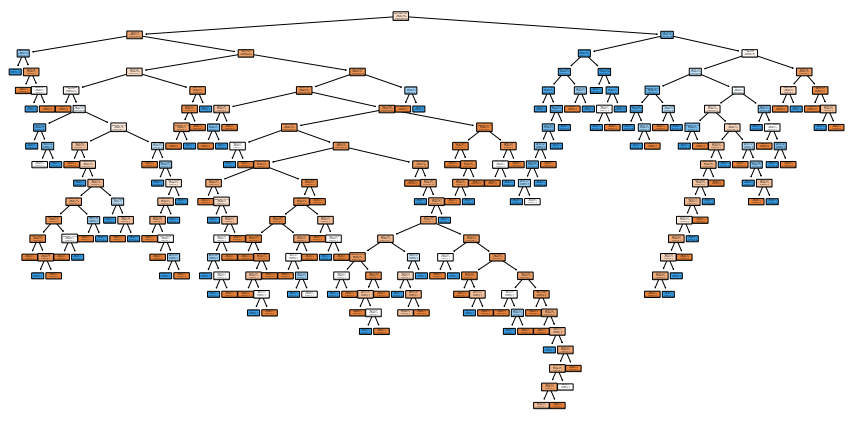

In [13]:
plt.figure(figsize=(15,7.5))
plot_tree(  clf_dt,
            filled = True,
            rounded = True,
            class_names = ["Didn't Survive", "Survived"],
            feature_names=X.columns)

&lt;sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1600cc2e6c8&gt;

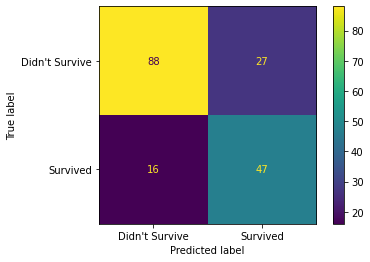

In [14]:
plot_confusion_matrix(clf_dt,X_test,Y_test,display_labels=["Didn't Survive","Survived"])

In the confusion matrix, we see that :

Of the 88+27 = 115 people that didn't survive, 88 (77%) were correctly classified.

Of the 16+47 =  63 people that survived, 47 (76%) were correctly classified.

# Submit Predictions

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.Survived.mean()

In [ ]:
from checkAccuracy import accuracy
print(accuracy)